# BH-spherical : Extract $g^{(n)}(0)$ and the probability distribution

* **authors** : D. Clément - A. Dareau
* **date** : 2022-12-22

Using boost-histogram analysis in spherical coordinates to analyze the local g^n

# imports

In [7]:
# -- global
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import boost_histogram as bh
from numpy.random import default_rng
from pathlib import Path
from tqdm import tqdm
from datetime import date
from scipy.special import erf, factorial, gamma
from collections import namedtuple 

plt.rcParams['figure.constrained_layout.use'] = True

In [8]:
import sys
mcp_path = '/Users/david/Documents/Physique/IOGS-Palaiseau/ApparatoSperimentale/Sperimenti/MCP-Measurement-master/'
sys.path.append(mcp_path)

fig_params = dict(figsize=(10, 5), constrained_layout=True)

In [9]:
# -- local
from mcp_meas.classes import DataCocktail, MCPViewer
from mcp_meas.functions.statistics import distributions as dist
from mcp_meas.functions.fullboost import spherical as fbs
from mcp_meas.functions.fullboost import spherical_slicing as ss

from mcp_meas.functions.statistics import counting_histogram as chist

In [10]:
# -- dataset list
mcp_path = '/Users/david/Documents/Physique/IOGS-Palaiseau/ApparatoSperimentale/Sperimenti/Optical_Lattices/FullCountingStat/'
sys.path.append(mcp_path)


data_root = Path('.') / 'data'
data_set = 'data_maker.mat'
#data_set = 'data_maker.pkl'

from datasets import DATASETS, SHIFT
print("\n".join(DATASETS.keys()))

UJ2
UJ5
UJ7.5
UJ10
UJ15
UJ20
UJ22_day1
UJ22_day2
UJ22clean
UJ22clean2
UJ22cold
UJ24
UJ24_250322
UJ24_290322
UJ24_150622
UJ24_160622
UJ24_recentered
UJ25
UJ26
UJ30
UJ30cold
UJ35
UJ76
UJ100
BECnoLattice


## local functions

### in / out 

In [11]:
# %% IN / OUT
def get_data(dset, v=True, plot=False, kr=0.1):
    # -- load
    cocktail = DataCocktail(data_root=data_root / DATASETS[dset], data_set=data_set)
    cocktail.verbose = False  # make it quiet
    cocktail.load_data()  # load the data
    cocktail.remove_empty_runs()  # remove empty runs
    if v:
        cocktail.display_data_info()
    if plot:
        viewer = MCPViewer(data=cocktail.copy_data())
        p = dict(
            kx_lim=(-kr, kr), 
            ky_lim=(-kr, kr), 
            kz_lim=(-kr, kr),
            figsize=(7, 2)
        )
        viewer.plot_2D(show=False, **p)
        viewer.plot_1D(**p)
    data = cocktail.to_dict()
    del cocktail
    return data

def figpath(dset, add=""):
    today = date.today()
    root = Path('.') / "figures"
    name = f"{today:%Y-%m-%d}_{dset}"
    if add:
        name += f"_{add}"
    name += ".png"
    return root / name

def gen_random_run(run, v=0):
    run = np.asanyarray(run)
    rng = default_rng()
    if v == 0:
        n_run = np.max(run)
        rand_run = rng.integers(0, int(n_run)+1, run.shape)
    elif v==1:
        rng = default_rng()
        rand_run = 1.0 * run
        rng.shuffle(rand_run)
    else:
        print("ERROR, v not implemented")
        rand_run = run
    return rand_run

### plotting

In [12]:
def plot_density(res, ax=None, cd="k", p=dict(fmt="o")):
    ax = plt.gca() if ax is None else ax
    r = res["sc"]
    n_tot = r.n_at.value / r.vol.value
    n_tot_err = r.n_at.error / r.vol.value / np.sqrt(r.n_box)
    ax.errorbar(r.rc, n_tot, yerr=n_tot_err, **p)
    ax.plot(res["r"], res["d"], cd)
    ax.set_yscale("log")
    ax.grid()
    ax.set_xlabel("kr")
    ax.set_ylabel("density")
    
def plot_gn_per_slice(res, ax, imax=5):
    ax = plt.gca() if ax is None else ax
    gc = res["gc"]
    gr = res["gr"]
    nlist = np.sort(list(gc.gn.value.keys()))
    for i, rc in enumerate(gc.rc):
        if i >= imax:
            break
        # correlated
        gnc = np.array([gc.gn.value[n][i] for n in nlist])
        #gnc_err = np.array([gc.gn.error[n][i] / np.sqrt(gc.n_box[i]) for n in nlist])
        gnc_err = np.array([gc.gn.error[n][i]                        for n in nlist])
  
        #question David on 14/10/21: do we really need to divide the error by number of boxes here? 
        # the histogram analysis provides a std deviation for the g^n(0) value over the different boxes
        # and divided by the sqrt of the number of boxes corresponds to taking the std error of the mean
        
        #ax.set_yscale("log", nonpositive='clip')
        ax.errorbar(nlist, gnc, yerr=gnc_err, capsize=5, fmt=f":oC{i}", label=f"slice {i}")
        
        # random mix of data - bg correlations
        gnr = np.array([gr.gn.value[n][i] for n in nlist])
        #gnr_err = np.array([gr.gn.error[n][i] / np.sqrt(gc.n_box[i]) for n in nlist])
        gnr_err = np.array([gr.gn.error[n][i]                        for n in nlist])
        ax.errorbar(nlist, gnr, yerr=gnr_err, fmt=f"+C{i}")
    ax.grid()
    ax.set_xlabel("n")
    ax.set_ylabel("$g^{(n)}(0)$")
    
def plot_gn_one_slice(res, ax, i=0, pc=dict(fmt=":o"), pr=dict(fmt=":+")):
    ax = plt.gca() if ax is None else ax
    gc = res["gc"]
    gr = res["gr"]
    nlist = np.sort(list(gc.gn.value.keys()))
    gnc = np.array([gc.gn.value[n][i] for n in nlist])
    #gnc_err = np.array([gc.gn.error[n][i] / np.sqrt(gc.n_box[i]) for n in nlist])     
    gnc_err = np.array([gc.gn.error[n][i]                         for n in nlist])

   # question David on 14:10/21: there is no errorbars here, always equal to 0 when plotting....
    ax.errorbar(nlist, gnc, yerr=gnc_err, capsize=5, **pc)
   
    # random mix of data - bg correlations
    gnr = np.array([gr.gn.value[n][i] for n in nlist])
    #gnr_err = np.array([gr.gn.error[n][i] / np.sqrt(gc.n_box[i]) for n in nlist])
    gnr_err = np.array([gr.gn.error[n][i] for n in nlist])
    ax.errorbar(nlist, gnr, yerr=gnr_err,**pr)
    ax.grid()
    ax.set_xlabel("n")
    ax.set_ylabel("$g^{(n)}(0)$")
    
def plot_gn_one_slice_log(res, ax, i=0, pc=dict(fmt=":o"), pr=dict(fmt=":+")):
    ax = plt.gca() if ax is None else ax
    gc = res["gc"]
    gr = res["gr"]
    nlist = np.sort(list(gc.gn.value.keys()))
    gnc = np.array([gc.gn.value[n][i] for n in nlist])
    gnc_err = np.array([gc.gn.error[n][i] / np.sqrt(gc.n_box[i]) for n in nlist])   
     
    # question David on 14:10/21: there is no errorbars here, always equal to 0 when plotting....
    ax.set_yscale("log", nonpositive='clip')
    ax.errorbar(nlist, gnc, yerr=gnc_err, capsize=5, **pc)
   
    # random mix of data - bg correlations
    gnr = np.array([gr.gn.value[n][i] for n in nlist])
    gnr_err = np.array([gr.gn.error[n][i] / np.sqrt(gc.n_box[i]) for n in nlist])
    ax.errorbar(nlist, gnr, yerr=gnr_err, **pr)
    ax.grid()
    ax.set_xlabel("n")
    ax.set_ylabel("$g^{(n)}(0)$")  
    

# Extracting magnitudes $g^{(n)}(0)$ of correlation functions

Here we extract the magnitudes of correlation function with spherical coordinates. We define: 

(i) the "start" radius (take start=0 to have a first sphere centered on k=0) in units of k_d

(ii) the "stop" radius, in units of k_d

(iii) the number of slices "n_slice"

So that the volume comprised between the start and stop radius is divided into "n_slice" slices of equal width.

To compute the magnitudes of correlation functions in a central sphere of radius 0.05k_d, use "start"=0, "stop"=0.05 and "n_slice"=1

## From one dataset

In [13]:
res = {}

In [14]:
# %% LOAD AND PROCESS

# - settings
dset = "UJ5"#"BECnoLattice"#"UJ24_290322"#

p_hist = dict(start=0.0, stop=.028, n_slice=1)

p_gn = dict(n=10)
# - load data
data = get_data(dset, v=False, plot=False, kr=1)
# - convert to spherical
kr, kth, kph = ss.cart2sph(data["kx"], data["ky"], data["kz"])
run = data["run"]
rand_run = gen_random_run(run)
dlist = [kr, kth, kph, run]
del data
res["kr"] = kr
res["kth"] = kth
res["kph"] = kph
# -- compute density
r, d = fbs.compute_radial_density(kr, 0, p_hist["stop"] + 0.05, 100, use_tqdm=False, norm_to_center=False)
res["d"] = d / np.max(run)
res["r"] = r
# -- compute histogram
res["hc"] = fbs.slice_histogram(*dlist, **p_hist)
res["hr"] = fbs.slice_histogram(*dlist[:-1], rand_run, **p_hist)
# -- extract statistics
for k in "cr":
    res[f"s{k}"] = fbs.extract_radial_stats(res[f"h{k}"])
# -- extract gn
for k in "cr":
    res[f"g{k}"] = fbs.extract_radial_gn(res[f"h{k}"], **p_gn)

Correlations: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


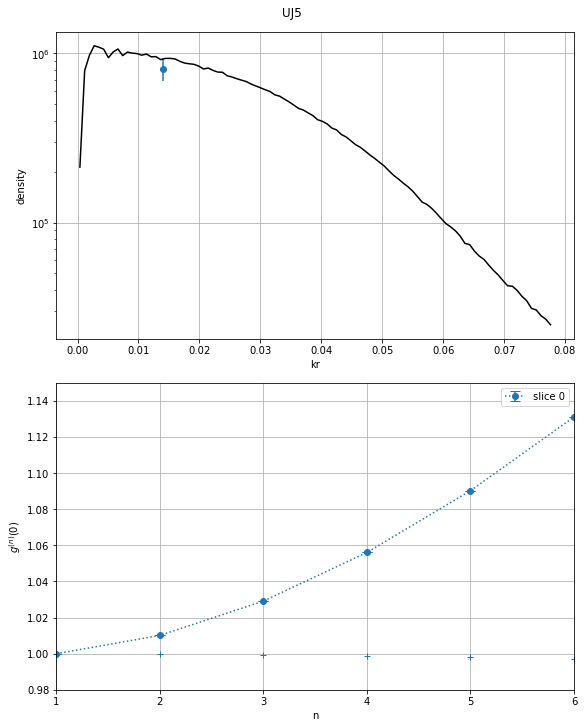

Data correlation amplitudes:
[1.         1.01012512 1.02914347 1.05611013 1.09029339 1.13111674
 1.17811343 1.230891   1.2891045  1.35243697]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Randomized data correlation amplitudes:
[1.         0.99986101 0.99953153 0.99897017 0.9981514  0.9970714
 0.99575363 0.99425364 0.99266251 0.99110815]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
# %% PLOT SLICE BY SLICE

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# -- density
cax = ax[0]
plot_density(res, cax)
#plt.ylim(0.9,1.2)

# -- gn
cax = ax[1]
plot_gn_per_slice(res, cax, imax=10)
cax.legend()
#plt.ylim([0.95,1.5])

#cax = ax[1]
#plot_gn_one_slice(res, cax)
#cax.legend()
#plt.ylim([0.5,1000])
#plt.ylim([0.7,3.5])

#x = np.linspace(1, 6, 1000)
#plt.plot(x, gamma(x+1),'--',color='black',label='$n!$')
#plt.legend()
#plt.semilogy()
plt.ylim(0.98,1.15)
plt.xlim(1,6)

fig.suptitle(dset)
plt.show()

den = res["sc"]
gc = res["gc"]
gr = res["gr"]

nlist = np.sort(list(gc.gn.value.keys()))
itest=0

gnc = np.array([gc.gn.value[n][itest] for n in nlist])
#gnc_err = np.array([gc.gn.error[n][i] / np.sqrt(gc.n_box[i]) for n in nlist])     
gnc_err = np.array([gc.gn.error[n][itest] for n in nlist])
print("Data correlation amplitudes:")
print(gnc)
print(gnc_err)

gnr = np.array([gr.gn.value[n][itest] for n in nlist])
#gnc_err = np.array([gc.gn.error[n][i] / np.sqrt(gc.n_box[i]) for n in nlist])     
gnr_err = np.array([gr.gn.error[n][itest] for n in nlist])
print("Randomized data correlation amplitudes:")
print(gnr)
print(gnr_err)

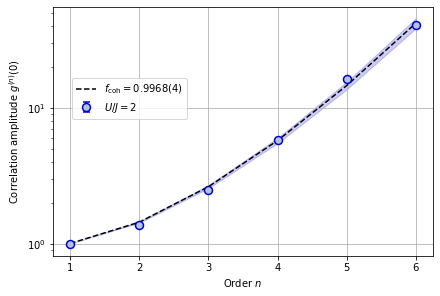

In [16]:
xn=[1., 2, 3 , 4, 5 ,6]
gn2=[ 1.       ,   1.37549125 , 2.46260111 , 5.80699138 ,16.27163783 ,40.87243344]
gn2err=[0.01599943, 0.01592973, 0.01587096, 0.01582181, 0.01578121, 0.01574829]

xnth=[1., 2, 3 , 4, 5 ,6]

fc=0.75
delta=0.01

gn2th=[1, 1 + 2*fc*(1-fc) + (1 - fc)**2  , 1  + 6 * fc**2 *(1 - fc) + 15 * fc *(1 - fc)**2 +  5*(1 - fc)**3, 
 1 + 12*fc**3 *(1 - fc) + 66* fc**2 *(1 - fc)**2 + 92 * fc * (1 - fc)**3 + 23 * (1 - fc)**4,
 1 + 20*fc**4 *(1 - fc) + 190* fc**3 *(1 - fc)**2 + 590 * fc**2 * (1 - fc)**3 + 595 *fc *(1 - fc)**4 + 119 * (1-fc)**5, 
 1 + 30*fc**5 *(1 - fc) + 435* fc**4 *(1 - fc)**2 + 2380 * fc**3 * (1 - fc)**3 + 5385 *fc**2 *(1 - fc)**4 + 4314 *fc *(1 - fc)**5 + 719 * (1-fc)**6
       ]

fc=fc+delta;
gn2th1=[1, 1 + 2*fc*(1-fc) + (1 - fc)**2  , 1  + 6 * fc**2 *(1 - fc) + 15 * fc *(1 - fc)**2 +  5*(1 - fc)**3, 
 1 + 12*fc**3 *(1 - fc) + 66* fc**2 *(1 - fc)**2 + 92 * fc * (1 - fc)**3 + 23 * (1 - fc)**4,
 1 + 20*fc**4 *(1 - fc) + 190* fc**3 *(1 - fc)**2 + 590 * fc**2 * (1 - fc)**3 + 595 *fc *(1 - fc)**4 + 119 * (1-fc)**5,  
 1 + 30*fc**5 *(1 - fc) + 435* fc**4 *(1 - fc)**2 + 2380 * fc**3 * (1 - fc)**3 + 5385 *fc**2 *(1 - fc)**4 + 4314 *fc *(1 - fc)**5 + 719 * (1-fc)**6
       ]

fc=fc-2*delta;
gn2th2=[1, 1 + 2*fc*(1-fc) + (1 - fc)**2  , 1  + 6 * fc**2 *(1 - fc) + 15 * fc *(1 - fc)**2 +  5*(1 - fc)**3, 
 1 + 12*fc**3 *(1 - fc) + 66* fc**2 *(1 - fc)**2 + 92 * fc * (1 - fc)**3 + 23 * (1 - fc)**4,  
 1 + 20*fc**4 *(1 - fc) + 190* fc**3 *(1 - fc)**2 + 590 * fc**2 * (1 - fc)**3 + 595 *fc *(1 - fc)**4 + 119 * (1-fc)**5, 
 1 + 30*fc**5 *(1 - fc) + 435* fc**4 *(1 - fc)**2 + 2380 * fc**3 * (1 - fc)**3 + 5385 *fc**2 *(1 - fc)**4 + 4314 *fc *(1 - fc)**5 + 719 * (1-fc)**6
       ]

fig,ax=plt.subplots(1,1)

plt.errorbar(xn,gn2,yerr=gn2err, marker='o',markersize=8,capsize=3.5,elinewidth=1.5,capthick=1.5, 
             linestyle='none',         color='mediumblue',
        markeredgecolor='mediumblue',
        markerfacecolor='lightsteelblue',
             markeredgewidth=1.5,lw=1.5,label=r'$U/J=2$')
plt.plot(xnth,gn2th,'--',color='black',label=r'$f_{\rm coh}=0.9968(4)$')
plt.fill_between(xnth,gn2th1, gn2th2,color='mediumblue',alpha=.2)
plt.semilogy()
#plt.ylim(0.95,1.15)
plt.grid(True)
plt.xlabel('Order $n$')
plt.ylabel(r'Correlation amplitude $g^{(n)}(0)$')
plt.legend(loc=[0.05,0.55])

plt.show()

## Compare different datasets

In [17]:
coll = {}

In [18]:
#dset_list = ["UJ2", "UJ5", "UJ7.5", "UJ10", "UJ12.5", "UJ15", "UJ20"]
#dset_list = ["UJ2", "UJ5","UJ7.5", "UJ10", "UJ15", "UJ20", "UJ25", "UJ30", "UJ35"]
#dset_list = [ "UJ25", "UJ30", "UJ35"]
dset_list = ["UJ24_250322", "UJ24_290322", "UJ24_150622", "UJ24_160622", "UJ24_recentered"]
#dset_list = [ "UJ5", "UJ20"]
p_hist = dict(start=0, stop=0.06, n_slice=2)
p_gn = dict(n=6)

In [19]:
# %% LOAD AND PROCESS
for dset in dset_list:
    print(f">>>>> {dset}")
    # - settings
    res={}
    # - load data
    data = get_data(dset, v=False, plot=False, kr=0.2)
    # - convert to spherical
    kr, kth, kph = ss.cart2sph(data["kx"], data["ky"], data["kz"])
    run = data["run"]
    rand_run = gen_random_run(run)
    dlist = [kr, kth, kph, run]
    del data
    res["kr"] = kr
    res["kth"] = kth
    res["kph"] = kph
    # -- compute density
    r, d = fbs.compute_radial_density(kr, 0, p_hist["stop"] + 0.05, 100, use_tqdm=False, norm_to_center=False)
    res["d"] = d / np.max(run)
    res["r"] = r
    # -- compute histogram
    res["hc"] = fbs.slice_histogram(*dlist, **p_hist)
    res["hr"] = fbs.slice_histogram(*dlist[:-1], rand_run, **p_hist)
    # -- extract statistics
    for k in "cr":
        res[f"s{k}"] = fbs.extract_radial_stats(res[f"h{k}"])
    # -- extract gn
    for k in "cr":
        res[f"g{k}"] = fbs.extract_radial_gn(res[f"h{k}"], **p_gn)
    # -- store
    coll[dset] = res

>>>>> UJ24_250322


Correlations: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


>>>>> UJ24_290322


Correlations: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


>>>>> UJ24_150622


Correlations: 100%|██████████| 2/2 [00:00<00:00, 34.72it/s]


>>>>> UJ24_160622


Correlations: 100%|██████████| 2/2 [00:00<00:00, 27.88it/s]


>>>>> UJ24_recentered


Correlations: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


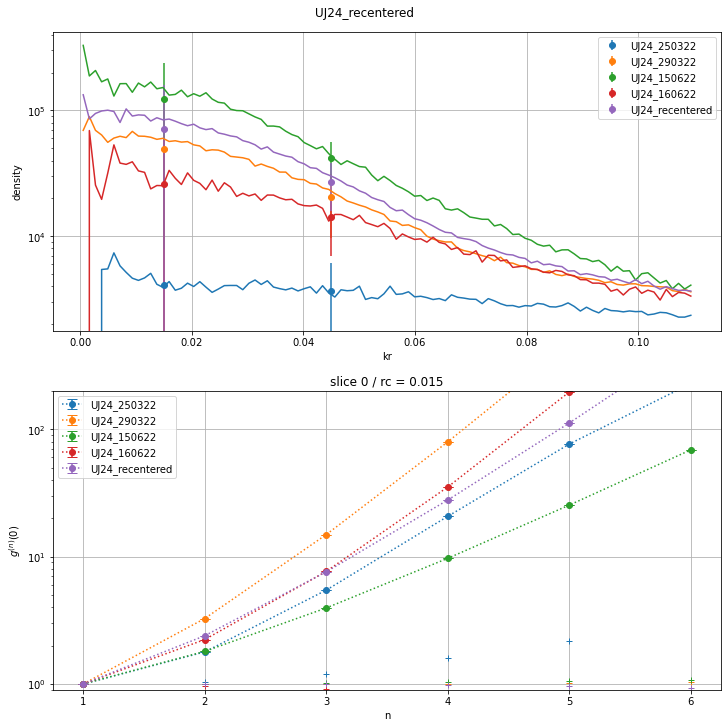

In [20]:
# %% PLOT SLICE BY SLICE

nslice = 1
fig, ax = plt.subplots(nslice + 1, 1, figsize=(10, 5 * (nslice + 1)))

i_plot = 0
for dset, res in coll.items():
    # -- format
    p = dict(fmt=f"oC{i_plot}", label=dset)
    pc = dict(fmt=f":oC{i_plot}", label=dset)
    pr = dict(fmt=f"+C{i_plot}")
    # -- density
    cax = ax[0]
    plot_density(res, cax, cd=f"C{i_plot}", p=p)
    # -- gn
    for i_slice in range(nslice):
        cax = ax[i_slice + 1]
        plot_gn_one_slice(res, cax, i_slice, pc, pr)
        rc = res["sc"].rc[i_slice]
        cax.set_title(f"slice {i_slice} / rc = {rc:.2g}")
        cax.set_ylim(0.9, 200)
        cax.semilogy()
    i_plot += 1
    
for cax in ax:
    cax.legend()

fig.suptitle(dset)
#out_fig = figpath("ALL_v3", "gn_per_slice_center_zoom")
#plt.savefig(out_fig, dpi=300)
plt.show()

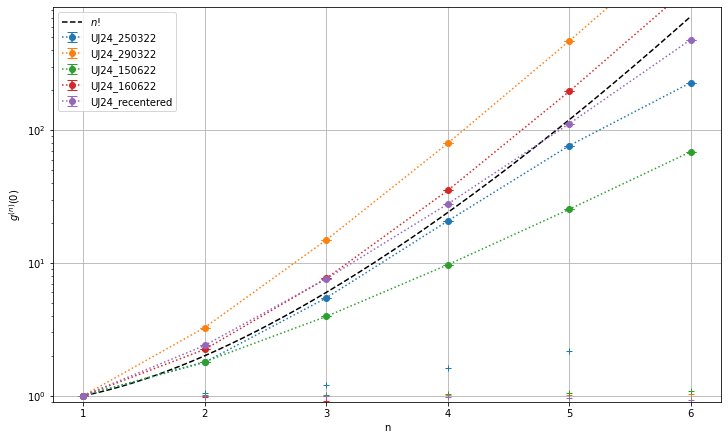

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

i_slice=0
i_plot = 0

for dset, res in coll.items():
    # -- format
    p = dict(fmt=f"oC{i_plot}", label=dset)
    pc = dict(fmt=f":oC{i_plot}", label=dset)
    pr = dict(fmt=f"+C{i_plot}")
    
    rc = res["sc"].rc[i_slice]
    plot_gn_one_slice_log(res, ax, i_slice, pc, pr)
    #ax.set_title(f"slice {i_slice} / rc = {rc:.2g}")
    ax.set_ylim(0.9, 850)
    ax.grid()
    ax.legend()
    i_plot += 1

    
x = np.linspace(1, 6, 500)
ax.plot(x, gamma(x+1),'--',color='black',label='$n!$')
ax.legend()
ax.grid()
#fig.suptitle(dset)
#out_fig = figpath("ALL_v3", "gn_per_slice_center_zoom")

plt.savefig('Fig-gn-BEC-largeUsuJ.pdf', dpi=300)
plt.show()


# Counting statistics - probability distribution

Compute the probability distribution P(N) to find a number N of atoms into a chosen volume

In [22]:
# -- settings
import sys
mcp_path = '/Users/david/Documents/Physique/IOGS-Palaiseau/ApparatoSperimentale/Sperimenti/Optical_Lattices/FullCountingStat/data'
sys.path.append(mcp_path)

data_root = Path('.')/"data"

#data_set="BEC-noLattice/data_maker.mat"
data_set="Lattice_data_UJ5_merged_without_31/data_maker.mat"


#data_set="Lattice_data_UJ76/data_maker.mat"
#data_set="Mott-sub-samples/mott_data_subset_6.mat"


# -- load
cocktail = DataCocktail(data_root=data_root, data_set=data_set)
cocktail.verbose = False  # make it quiet
cocktail.load_data()  # load the data
cocktail.remove_empty_runs()  # remove empty runs
cocktail.display_data_info() 

+ file loaded : data/Lattice_data_UJ5_merged_without_31/data_maker.mat
+ run number  : 2367
+ atom number : 2.38e+06
+ empty runs  : 0
+ atom / run  :
    > mean : 1.00e+03
    > max  : 1.30e+03
    > min  : 7.01e+02
    > std  : 1.62e+02


## Plot density

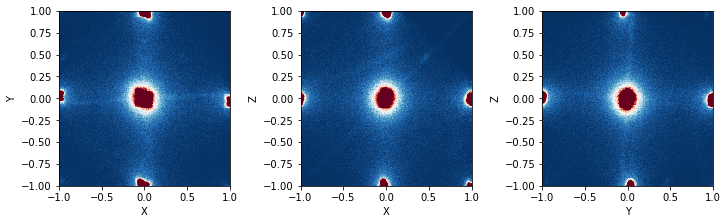

In [23]:
# -- show density profile
# data
data = cocktail.copy_data()
viewer = MCPViewer(data=data)

# plot 2D
hist2D_opts = dict(kx_lim=(-1, 1),
                   ky_lim=(-1, 1),
                   kz_lim=(-1, 1),
                   bins=(200, 200))

colormesh_opts = dict(cmap='RdBu_r',
                      vmin=0,
                      vmax=200)

fig, ax = viewer.plot_2D(figsize=(10, 3),
                         colormesh_opts=colormesh_opts,
                         show=True,
                         **hist2D_opts)

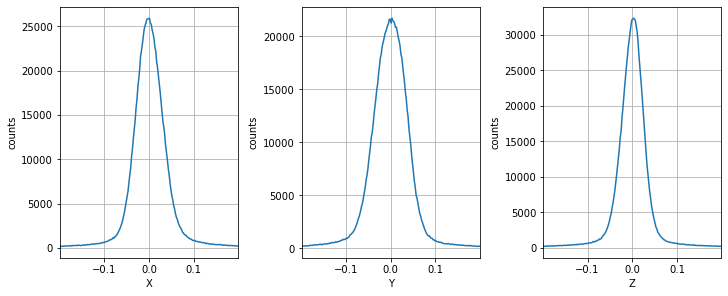

In [24]:
k_range = .2
k_lim = (-k_range, k_range)
hist1D_opts = dict(kx_lim=k_lim,
                   ky_lim=k_lim,
                   kz_lim=k_lim)
fig, ax = viewer.plot_1D(**hist1D_opts)

## Compute counting statistics

### Step by step example

In [25]:
# -- export data to list
data = cocktail.to_list()
print('Number of shots ',len(data))
#print(len(data[0]))

# -- compute distribution for one run
# take one run
k = data[0]  # (kx, ky, kz)
# compute histograms for a list of bin size `dk_bin_list`
res = chist.count_hist_old(k,
                       k_range=0.2,
                       dk_bin_list=np.array([0.05,0.1]),
                       remove=True,
                       shift=(0,0,0),
                       expand_range_if_needed=False
                      )

# get result
hist, bins, N = res
#print(bins)  # list of the bins sizes
#print(hist[0].shape)  # hist is a list of histograms

Number of shots  2367


In [26]:
# -- compute the momentum distribution for each run

# settings for UJ5 data
#k_range = 0.04
#k_bin = 0.02

# settings for UJ24 data
#k_range = 0.1
#k_bin = 0.03

# settings for Mott UJ76 data
k_range = 0.015
k_bin = 0.015

params = {"k_range": k_range, "dk_bin_list": np.array([k_bin])}

# compute
out = chist.batch_process_count_hist_old(data, n_proc=4, **params)

# -- result 
# out contains a list of (hist, bins, N), one for each run
print(len(out))  
# lets look at the first run
res = out[0]
print(res[1])  #  res[1] = bins
print(res[0][0].shape) #  res[0] = hist

100%|██████████| 2367/2367 [00:00<00:00, 4110.87it/s]

2367
[0.015]
(2, 2, 2)


In [27]:
# -- Gather all
# let's gather all histograms into one array
# get array size
n_runs = len(out)
nx, ny, nz = out[0][0][0].shape
dk = out[0][1]  # bin size
# init array
atoms = np.zeros((n_runs, nx, ny, nz))
# get all atoms
for i_run, run in tqdm(enumerate(out)):
        atoms[i_run, :, :, :] = run[0][0]
        
# -- compute mean atom number for each cell
N_boxes = nx * ny * nz
n_mean = np.zeros_like(atoms[0, :, :, :])
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            n_mean[i,j,k] = np.mean(atoms[:,i,j,k])
            
# -- filter
# keep box with more than half the max atom mean number
filter_frac = 0.5  
n_min = filter_frac * np.max(n_mean)
i_filter = n_mean > n_min
#print(len(np.ravel(atoms[0,i_filter])))

# -- histogram
hist_max = np.max(atoms[:, i_filter])
bins = np.arange(-0.5, hist_max + 0.5, 1)
hist, bin_edges = np.histogram(atoms[:, i_filter], bins, density=True)
bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2
x = np.linspace(0, hist_max, 1000)

# -- theoretical distributions
thermal = dist.thermal(x, np.mean(atoms[:, i_filter]))
poisson = dist.poisson(x, np.mean(atoms[:, i_filter]))
print(np.mean(atoms[:, i_filter]))

2367it [00:00, 409533.77it/s]

3.128485424588086


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
[0.04510405 0.14249498 0.21062639 0.21448188 0.1783564  0.10864054
 0.06084293 0.02498151 0.00855604 0.00417239 0.00137319 0.00036971]


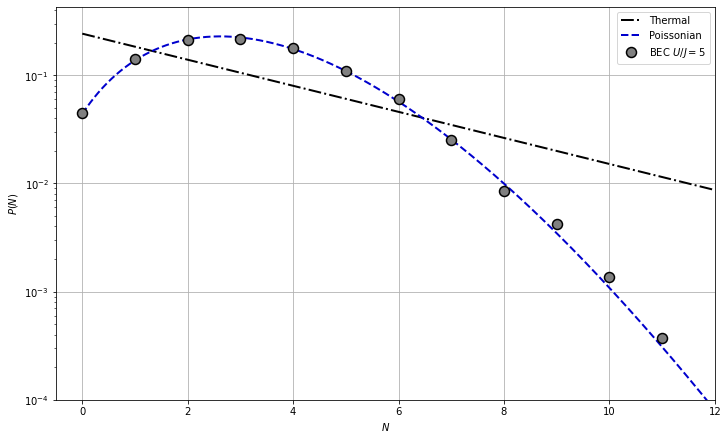

In [28]:
# -- plot
plt.figure(figsize=[10,6])

print(bin_centers)
print(hist)

# kmk data
#plt.errorbar(bin_centers, hist, 
#         marker='o',markersize=8,capsize=3.5,elinewidth=1.5,capthick=1.5,
#        linestyle='none', color='mediumblue',
#        markeredgecolor='mediumblue',
#        markerfacecolor='lightsteelblue',
#        markeredgewidth=1.5,lw=1.5,label=r'$U/J=20$')

# Mott data
plt.errorbar(bin_centers, hist, 
    marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5, 
             linestyle='none',         color='black',
        markeredgecolor='black',
        markerfacecolor='gray',
             markeredgewidth=1.5,lw=1.5, label=r"BEC $U/J=5$")

plt.plot(x, thermal,'-.',linewidth=2,color='black',label='Thermal')
plt.plot(x, poisson,'--',linewidth=2,color='mediumblue',label='Poissonian')

# Mott data
plt.semilogy()
plt.ylim(1e-4, 2 * hist.max())
plt.xlim(-0.5,12)
#SF data
#plt.ylim(-.01, 1.2 * hist.max())

plt.grid()
plt.legend()
plt.ylabel(r'$P(N)$')
plt.xlabel(r'$N$')

#plt.savefig('CountingStat-Mott.pdf', dpi=300,bbox_inches='tight')
#plt.savefig('CountingStat-UJ5.pdf', dpi=300,bbox_inches='tight')
plt.savefig('CountingStat-UJ5.pdf', dpi=300,bbox_inches='tight')
plt.show()

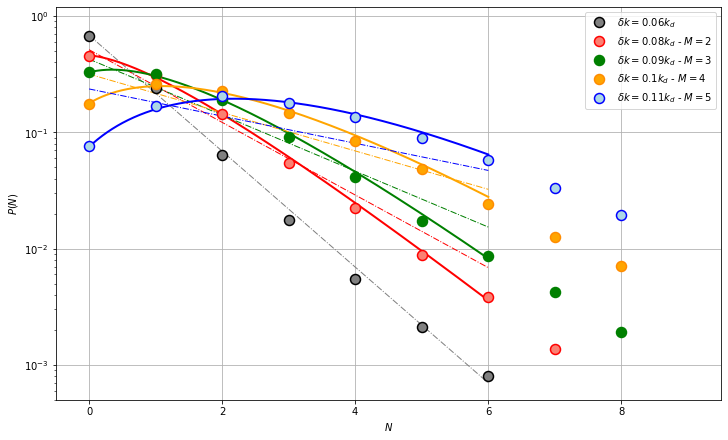

In [37]:
#Mott subsets @ u=76
x_order=[0., 1., 2., 3., 4., 5., 6., 7., 8.]

data_Mott_dk0p03=[9.36140758e-01, 5.93433216e-02, 4.14191935e-03, 3.12597687e-04, 4.46568124e-05, 
                  1.67463046e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
data_Mott_dk0p04=[8.66522132e-01, 1.15136689e-01, 1.53616064e-02, 2.37670137e-03, 4.75340274e-04, 
                  6.95619913e-05, 5.79683261e-05, 0.00000000e+00, 0.00000000e+00]
data_Mott_dk0p06=[6.67195052e-01, 2.42606933e-01, 6.35621849e-02, 1.75666545e-02, 5.50906918e-03, 
                  2.13086638e-03, 8.05571436e-04, 0.00000000e+00, 0.00000000e+00]
data_Mott_dk0p08=[4.52845762e-01, 3.10557669e-01, 1.43902964e-01, 5.40802412e-02, 2.21057920e-02,
                  8.75619034e-03, 3.83980478e-03, 1.36366899e-03, 0]
data_Mott_dk0p09=[3.28281348e-01, 3.15553695e-01, 1.89156374e-01, 9.05589282e-02, 4.09462005e-02,
                  1.72074524e-02, 8.66652711e-03, 4.18672807e-03, 1.92589491e-03]
data_Mott_dk0p1=[1.76599887e-01, 2.60126861e-01, 2.27720907e-01, 1.47836463e-01, 8.34641713e-02, 
                 4.81065126e-02, 2.41160585e-02, 1.26860516e-02, 7.09665264e-03]
data_Mott_dk0p11=[1.20077875e-01, 2.14030019e-01, 2.23261948e-01, 1.69252025e-01, 1.17377379e-01,
                  6.63819632e-02, 3.77441437e-02, 2.13527602e-02, 1.01739622e-02]
data_Mott_dk0p12=[7.67104933e-02, 1.69332552e-01, 2.04672975e-01, 1.80051922e-01, 1.35750775e-01,
                  8.93560003e-02, 5.71978896e-02, 3.34142869e-02, 1.92613684e-02] 


plt.figure(figsize=[10,6])

plt.errorbar(x_order, data_Mott_dk0p06, 
    marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5, 
             linestyle='none',         color='black',
        markeredgecolor='black',
        markerfacecolor='gray',
             markeredgewidth=1.5,lw=1.5, label='$\delta k =0.06 k_d$')
thermal = dist.thermal(x, 0.4649)
plt.plot(x, thermal,'-.',linewidth=1,color='gray')

plt.errorbar(x_order, data_Mott_dk0p08, 
    marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5, 
             linestyle='none',         color='red',
        markeredgecolor='red',
        markerfacecolor='salmon',
             markeredgewidth=1.5,lw=1.5, label='$\delta k =0.08 k_d$ - $M=2$')
thermal = dist.thermal(x, 0.9494)
plt.plot(x, thermal,'-.',linewidth=1,color='red')
multi_thermal = dist.multi_thermal(x, 2, 0.9494)
plt.plot(x, multi_thermal,'-',linewidth=2,color='red')

plt.errorbar(x_order, data_Mott_dk0p09, 
    marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5, 
             linestyle='none',         color='green',
        markeredgecolor='green',
        markerfacecolor='green',
             markeredgewidth=1.5,lw=1.5, label='$\delta k =0.09 k_d$ - $M=3$')
thermal = dist.thermal(x, 1.35)
plt.plot(x, thermal,'-.',linewidth=1,color='green')
multi_thermal = dist.multi_thermal(x, 3, 1.35)
plt.plot(x, multi_thermal,'-',linewidth=2,color='green')

plt.errorbar(x_order, data_Mott_dk0p1, 
    marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5, 
             linestyle='none',       
        markeredgecolor='darkorange',
        markerfacecolor='orange',
             markeredgewidth=1.5,lw=1.5, label='$\delta k =0.1 k_d$ - $M=4$')
thermal = dist.thermal(x, 2.161)
plt.plot(x, thermal,'-.',linewidth=1,color='orange')
poisson = dist.multi_thermal(x, 4, 2.161)
plt.plot(x, poisson,'-',linewidth=2,color='orange')

plt.errorbar(x_order, data_Mott_dk0p12, 
    marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5, 
             linestyle='none',       
        markeredgecolor='blue',
        markerfacecolor='lightblue',
             markeredgewidth=1.5,lw=1.5, label='$\delta k =0.11 k_d$ - $M=5$')
thermal = dist.thermal(x, 3.24)
plt.plot(x, thermal,'-.',linewidth=1,color='blue')
poisson = dist.multi_thermal(x, 6, 3.24)
plt.plot(x, poisson,'-',linewidth=2,color='blue')

#plt.plot(x_order,data_Mott_sub6,'o')

plt.semilogy()
plt.ylim(5e-4, 1.2)
plt.xlim(-0.5,9.5)

plt.grid()
plt.legend()
plt.ylabel(r'$P(N)$')
plt.xlabel(r'$N$')

plt.savefig('CountingStatMott-variousdk.pdf', dpi=300,bbox_inches='tight')
plt.show()